In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from plotting_constants import carrier_colors, nice_carrier_names, policy_colors

In [2]:
z = Path.cwd().parent / 'summaries' / 'total_unit_revenues_flex_zonal.csv'
n = Path.cwd().parent / 'summaries' / 'total_unit_revenues_flex_national.csv'

z = pd.read_csv(z, parse_dates=True, index_col=[0,1])
n = pd.read_csv(n, parse_dates=True, index_col=[0,1])

C:\Users\lukas\AppData\Local\Temp\ipykernel_31676\301094810.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  z = pd.read_csv(z, parse_dates=True, index_col=[0,1])
C:\Users\lukas\AppData\Local\Temp\ipykernel_31676\301094810.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  z = pd.read_csv(z, parse_dates=True, index_col=[0,1])
C:\Users\lukas\AppData\Local\Temp\ipykernel_31676\301094810.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  n = pd.read_csv(n, parse_dates=True, index_col=[0,1])
C:\Users\lukas\AppData\Local\Temp\ipykernel_31676\301094810.py:5: UserWarning: Cou

In [3]:
p = Path.cwd().parent / 'summaries' / 'total_unit_revenues_flex.csv'
p = pd.read_csv(p, parse_dates=True, index_col=[0,1,2])

C:\Users\lukas\AppData\Local\Temp\ipykernel_31676\2131312563.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  p = pd.read_csv(p, parse_dates=True, index_col=[0,1,2])
C:\Users\lukas\AppData\Local\Temp\ipykernel_31676\2131312563.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  p = pd.read_csv(p, parse_dates=True, index_col=[0,1,2])
C:\Users\lukas\AppData\Local\Temp\ipykernel_31676\2131312563.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  p = pd.read_csv(p, parse_dates=True, index_col=[0,1,2])


In [4]:
idx = pd.IndexSlice

keepers = ['bid_cost', 'cfd', 'offer_cost', 'roc', 'wholesale']

z = p.loc[idx[:,'zonal', keepers], :]
n = p.loc[idx[:,'national', keepers], :]

z.index = z.index.droplevel(1)
n.index = n.index.droplevel(1)

# Rename index values in level 1 for both dataframes
rename_dict = {
    'cfd': 'cfd_revenue',
    'roc': 'roc_revenue',
    'wholesale': 'wholesale_revenue'
}

# Apply renaming to z dataframe
z.index = pd.MultiIndex.from_tuples(
    [(asset, rename_dict.get(revenue_type, revenue_type)) 
     for asset, revenue_type in z.index],
    names=z.index.names
)

# Apply renaming to n dataframe
n.index = pd.MultiIndex.from_tuples(
    [(asset, rename_dict.get(revenue_type, revenue_type)) 
     for asset, revenue_type in n.index],
    names=n.index.names
)

n.sort_index(inplace=True)
z.sort_index(inplace=True)

C:\Users\lukas\AppData\Local\Temp\ipykernel_31676\3570653476.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n.sort_index(inplace=True)
C:\Users\lukas\AppData\Local\Temp\ipykernel_31676\3570653476.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z.sort_index(inplace=True)


In [5]:
cfd = pd.read_csv(Path.cwd().parent / 'data' / 'prerun' / 'cfd_strike_prices.csv', index_col=0)

In [6]:
bmus = pd.read_csv(Path.cwd().parent / 'data' / 'prerun' / 'prepared_bmus.csv', index_col=0)

import yaml

with open(Path.cwd().parent / 'data' / 'interconnection_helpers.yaml', 'r') as f:
    inter_bmu = yaml.safe_load(f)['interconnection_mapper']

intercon_lats = []

for i, (key, item) in enumerate(inter_bmu.items()):

    if key == 'Nemo':
        intercon_lats.append(0)
        continue

    lat = bmus.loc[bmus.index.str.startswith(item[0]+'-'), 'lat'].dropna().astype(float).mean()
    intercon_lats.append(lat)

intercon_lats = pd.Series(intercon_lats, index=inter_bmu.keys())

intercon_lats.loc['EastWest'] = 53.23
intercon_lats.loc['Moyle'] = 55.07
intercon_lats.loc['Nemo'] = 51.297

intercon_lats = intercon_lats.to_frame().rename(columns={0: 'lat'})

In [7]:
bmus = pd.read_csv(Path.cwd().parent / 'data' / 'prerun' / 'prepared_bmus.csv', index_col=0)

bmus = bmus.loc[~(bmus['lat'] == 'distributed')]
bmus.loc[:,'lat'] = bmus['lat'].astype(float)

bmu_carriers = pd.concat((
    bmus['carrier'],
    pd.Series('interconnector', intercon_lats.index)
))

bmus = pd.concat([bmus['lat'], intercon_lats])

In [8]:
nice_revenue_names = {
    "wholesale_revenue": "Revenue Change (%) \n Wholesale",
    "roc_revenue": "Revenue Change (%) \n ROC",
    "cfd_revenue": "Revenue Change (%) \n Contracts for Differences",
}

In [9]:
def plot_carrier_share(series, base_ax, coords):
    """
    Plots the carrier share distribution as a horizontal bar on an additional axis.

    Parameters:
      series: Pandas Series with carriers as index and fractional share values.
      base_ax: A matplotlib Axes instance. An additional axis will be added to its figure.
      coords: A tuple or list of [left, bottom, width, height] in figure coordinates defining the new axis extent.
    """
  
      # new_ax = base_ax.figure.add_axes(coords)
    # new_ax = base_ax.add_axes(coords)
    new_ax = base_ax.inset_axes(coords)
    
    cumulative = 0  # keep track of the left boundary for each segment
    for carrier, share in series.items():
        # Convert the fractional share to a percentage width (since 1 -> 100%)
        segment_width = share * 100
        # Get the assigned color for this carrier, defaulting to 'gray' if missing
        color = carrier_colors.get(carrier, 'gray')
        # Draw a horizontal bar for this segment with no edge, for a smooth look
        new_ax.barh(0, width=segment_width, left=cumulative, height=1,
                    color=color, edgecolor='none')
        new_ax.axvline(cumulative, c='k', lw=0.5)

        cumulative += segment_width

    # Adjust the x-axis to run from 0 to 100 with ticks every 20%
    new_ax.set_xlim(0, 100)
    new_ax.set_xticks(list(range(0, 101, 20)))
    new_ax.set_yticks([])  # remove y-axis ticks
    xtick_labels = list(new_ax.get_xticks())
    xtick_labels[-1] = '100%'
    new_ax.set_xticklabels(xtick_labels)

    # new_ax.set_xlabel('(%)')
    # new_ax.set_title('Carrier Share Distribution')

In [10]:
fp = pd.read_excel(
    Path.cwd() / 'systemaveragepriceofgasdataset130225.xlsx',
    sheet_name=3,
    parse_dates=True,
    index_col=0,
    skiprows=1
    )

def process(df):

    df = (
        df.iloc[4:]
        .rename(
        columns={
            'Unnamed: 1': 'day_price',
            'Unnamed: 2': 'before_week_average',
        })
        .replace('[x]', np.nan)
        ['day_price']
        )
    df.index.name = 'date'
    df.index = pd.to_datetime(df.index)
    return df * 10

fp = process(fp)

thermal_plant_eta = 0.52
balancing_markup = 30

C:\Users\lukas\AppData\Local\Temp\ipykernel_31676\3361897111.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  fp = pd.read_excel(
C:\Users\lukas\AppData\Local\Temp\ipykernel_31676\3361897111.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace('[x]', np.nan)


In [11]:
dispatch = pd.read_csv(
    Path.cwd().parent / 'summaries' / 'total_unit_dispatch_flex.csv', index_col=[0,1,2]
)

dispatch

2022-01-01  2022-01-02  2022-01-03  2022-01-04  \
ABERU-1 national redispatch       23.00         0.0         0.0         0.0   
                 wholesale         0.00         0.0         0.0         0.0   
        zonal    redispatch        0.00         0.0         0.0         0.0   
                 wholesale         0.00         0.0         0.0         0.0   
ABRBO-1 national redispatch     1923.25      1612.5      1715.5      2165.5   
...                                 ...         ...         ...         ...   
LITRB-1 zonal    wholesale          NaN         NaN         NaN         NaN   
Viking  national redispatch         NaN         NaN         NaN         NaN   
                 wholesale          NaN         NaN         NaN         NaN   
        zonal    redispatch         NaN         NaN         NaN         NaN   
                 wholesale          NaN         NaN         NaN         NaN   

                             2022-01-05   2022-01-06  2022-01-07  2022-01-08  \
ABERU-1 national redispatch        0.00    54.256203         0.0         0.0   
                 wholesale         0.00     0.000000         0.0         0.0   
        zonal    redispatch        0.00     0.000000         0.0         0.0   
                 wholesale         0.00     0.000000         0.0         0.0   
ABRBO-1 national redispatch     1584.25  1439.750000       711.5       919.0   
...                                 ...          ...         ...         ...   
LITRB-1 zonal    wholesale          NaN          NaN         NaN         NaN   
Viking  national redispatch         NaN          NaN         NaN         NaN   
                 wholesale          NaN          NaN         NaN         NaN   
        zonal    redispatch         NaN          NaN         NaN         NaN   
                 wholesale          NaN          NaN         NaN         NaN   

                             2022-01-09   2022-01-10  ...    2024-12-22  \
ABERU-1 national redispatch         0.0   169.037103  ...  0.000000e+00   
                 wholesale          0.0   169.037103  ...  0.000000e+00   
        zonal    redispatch         0.0   169.037103  ...  0.000000e+00   
                 wholesale          0.0   169.037103  ...  0.000000e+00   
ABRBO-1 national redispatch       215.0  1417.750000  ...  1.512500e+03   
...                                 ...          ...  ...           ...   
LITRB-1 zonal    wholesale          NaN          NaN  ... -1.776357e-15   
Viking  national redispatch         NaN          NaN  ...  2.069011e+04   
                 wholesale          NaN          NaN  ...  2.069011e+04   
        zonal    redispatch         NaN          NaN  ...  2.302650e+04   
                 wholesale          NaN          NaN  ...  2.302650e+04   

                               2024-12-23    2024-12-24   2024-12-25  \
ABERU-1 national redispatch      0.000000     88.000000   160.000000   
                 wholesale       0.000000      0.000000     0.000000   
        zonal    redispatch      0.000000     64.000000     0.000000   
                 wholesale       0.000000      0.000000     0.000000   
ABRBO-1 national redispatch    687.000000    565.750000   848.500000   
...                                   ...           ...          ...   
LITRB-1 zonal    wholesale       0.000000      0.000000     0.000000   
Viking  national redispatch  15494.953986 -11966.667185  5466.160182   
                 wholesale   15494.953986 -11966.667185  5466.160182   
        zonal    redispatch  16314.310089  -7585.950198  9431.573663   
                 wholesale   16314.310089  -7585.950198  9431.573663   

                               2024-12-26    2024-12-27    2024-12-28  \
ABERU-1 national redispatch     88.000000    105.648706    123.500000   
                 wholesale      48.000000    105.648706     91.000000   
        zonal    redispatch     80.000000    105.648706    110.500000   
                 wholesale      48.000000    105.648706     9

In [12]:
from tqdm import tqdm

offers = []

for day in tqdm(pd.date_range(start='2022-01-01', end='2024-12-31', freq='D').strftime('%Y-%m-%d')):
    try:
        offers.append(pd.read_csv(
            Path.cwd().parent / 'data' / 'base' / day / 'offers.csv', index_col=[0,1], parse_dates=[0]))
    except FileNotFoundError:
        continue

offers = pd.concat(offers)

offers = offers.loc[idx[:, 'price'], :]
offers.index = offers.index.droplevel(1)
offers.index = offers.index.strftime('%Y-%m-%d %H:%M:%S')
offers = offers.groupby(offers.index.str[:10]).mean()

  0%|          | 0/1096 [00:00<?, ?it/s]

100%|██████████| 1096/1096 [00:10<00:00, 108.75it/s]


In [13]:
import os

thermal_costs = []
tc_path = Path.cwd().parent / 'data' / 'prerun' / 'thermal_costs'
for fn in tqdm(os.listdir(tc_path)):

    if fn.endswith('.csv'):
        tc = pd.read_csv(tc_path / fn, index_col=0).rename(columns={'0': fn.split('.')[0]})
        thermal_costs.append(tc)

thermal_costs = pd.concat(thermal_costs, axis=1)

100%|██████████| 173/173 [00:00<00:00, 329.18it/s]


In [14]:
bmus_alldata = pd.read_csv(Path.cwd().parent / 'data' / 'prerun' / 'prepared_bmus.csv', index_col=0)

def get_units(carrier):
    if isinstance(carrier, list):
        return bmus_alldata.loc[bmus_alldata.carrier.isin(carrier)].index
    else:
        units = bmus_alldata.loc[bmus_alldata.carrier.str.contains(carrier)].index

    return units

thermal_units = get_units(['fossil', 'biomass', 'coal'])

In [15]:
def get_plant_expenses(dispatch, mode, fp, thermal_plant_eta, balancing_markup):

    idx = pd.IndexSlice

    ss = dispatch.loc[idx[:, mode, :], :].copy()
    ss.index = ss.index.droplevel(1)

    red_ss = ss.loc[idx[:, 'redispatch'], :]
    red_ss.index = red_ss.index.get_level_values(0)

    who_ss = ss.loc[idx[:, 'wholesale'], :]
    who_ss.index = who_ss.index.get_level_values(0)

    bal_ss = (red_ss - who_ss).abs()

    total_mwh_delivered = red_ss

    ss = ss.groupby(level=0).sum()

    hold_fp = fp.copy()
    hold_fp.index = fp.index.strftime('%Y-%m-%d')

    # Create a result DataFrame with the same shape as ss
    result = pd.DataFrame(index=ss.index, columns=ss.columns)

    # Multiply all values in ss by the corresponding date values in fp
    # First align the columns of ss with the index of fp
    common_dates = ss.columns.intersection(hold_fp.index)

    result = pd.DataFrame(index=ss.index, columns=ss.columns)

    result.loc[:, common_dates] = (
        # ss.loc[:, common_dates].values *
        total_mwh_delivered.values *
        hold_fp.loc[common_dates].values.reshape(1, -1) /
        thermal_plant_eta
    )
    
    # Calculate total expenses per unit
    total_expenses = result.sum(axis=1).add(bal_ss.loc[result.index].sum(axis=1).mul(balancing_markup))
    
    # Calculate expenses per MWh delivered
    # Avoid division by zero
    total_mwh_delivered_sum = total_mwh_delivered.sum(axis=1)
    return total_expenses

    # expenses_per_mwh = total_expenses.div(total_mwh_delivered_sum.where(total_mwh_delivered_sum > 0, np.nan))
    # return expenses_per_mwh


zonal_expenses = get_plant_expenses(
    dispatch.loc[idx[thermal_units, :, :], :],
    'zonal',
    fp,
    thermal_plant_eta,
    balancing_markup
).mul(-1e-6)

national_expenses = get_plant_expenses(
    dispatch.loc[idx[thermal_units, :, :], :],
    'national',
    fp,
    thermal_plant_eta,
    balancing_markup
).mul(-1e-6)

In [16]:
n_exp = national_expenses.sort_values(ascending=False)
n_exp = n_exp.groupby(n_exp.index.str[:5]).sum()

n_rev = n.replace(np.nan, 0).groupby(level=0).sum().sum(axis=1).mul(1e-6)
# Group by first 5 characters of index and sum
n_rev_grouped = n_rev.groupby(n_rev.index.str[:5]).sum().loc[n_exp.index]

# Get total MWh delivered for each plant group
# Calculate revenue per MWh delivered

national_comparison = pd.concat((n_exp.rename('expenses'), n_rev_grouped.rename('revenue')), axis=1)
# national_comparison['expenses'] *= -1.

national_comparison['profit'] = national_comparison.sum(axis=1)

print(national_comparison.sort_values(by='profit'))

          expenses      revenue       profit
KEADG -1121.414137     6.032477 -1115.381659
RATS-  -3125.36897  2039.556303 -1085.812667
SOLUU  -1075.52713    11.787648 -1063.739483
LNMTH -1055.744796   106.913213  -948.831583
VKING  -669.750567    11.338548  -658.412019
...            ...          ...          ...
MRWD-  -113.474162  2143.424767  2029.950604
STAY- -1868.689223  4125.601919  2256.912696
DIDCB   -54.899264  2516.264060  2461.364796
PEMB- -2604.364025  6181.844386  3577.480361
DRAXX  -676.276183  6261.085628  5584.809444

[70 rows x 3 columns]


In [17]:
# Zonal expenses and revenue
z_exp = zonal_expenses.sort_values(ascending=False)
z_exp = z_exp.loc[z_exp > 0]
z_exp = z_exp.groupby(z_exp.index.str[:5]).sum()

z_rev = z.replace(np.nan, 0).groupby(level=0).sum().sum(axis=1)
# Group by first 5 characters of index and sum
z_rev_grouped = z_rev.groupby(z_rev.index.str[:5]).sum()

# Calculate revenue per MWh delivered
z_rev = z_rev_grouped.div(z_mwh_delivered.loc[z_exp.index].where(z_mwh_delivered.loc[z_exp.index] > 0, np.nan)).loc[z_exp.index]# .mul(1e-6)
z_rev = z_rev.groupby(z_rev.index.str[:5]).sum().loc[z_exp.index]# .mul(1e-6)

zonal_comparison = pd.concat((z_exp.rename('expenses').mul(-1), z_rev.rename('revenue')), axis=1)

zonal_comparison['profit'] = zonal_comparison.sum(axis=1)# .add(national_comparison['gap'].clip(lower=0))
# zonal_comparison['diff'] = zonal_comparison['revenue'] - zonal_comparison['expenses']

NameError: name 'z_mwh_delivered' is not defined

In [18]:
inter = thermal_units.str[:5].intersection(zonal_comparison.index)

profit_change = zonal_comparison['profit'].div(national_comparison['profit']).loc[inter].sort_values()

NameError: name 'zonal_comparison' is not defined

NameError: name 'profit_change' is not defined

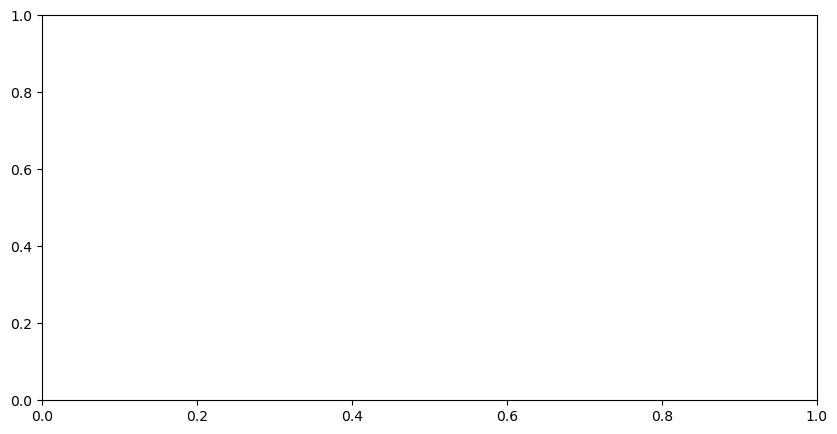

In [19]:
short_bmus = bmus.groupby(bmus.index.str[:5]).first()

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(short_bmus.loc[profit_change.index], profit_change.values * 100)
ax.set_ylabel('Thermal units surplus change [%]\nAssuming 10% surplus under national')

ax.set_xlabel('Latitude')
ax.grid(True)
ax.set_axisbelow(True)

ax.set_ylim(-200, 200)

plt.show()

In [20]:
national_comparison.loc[['PEHE-', 'MARK-', 'TSREP']]

,expenses,revenue,profit
PEHE-,-788.209868,2416.541361,1628.331493
MARK-,-571.986484,69.546255,-502.440229
TSREP,-346.823193,50.030618,-296.792575


In [21]:
zonal_comparison.loc[['PEHE-', 'MARK-', 'TSREP']]

NameError: name 'zonal_comparison' is not defined

In [22]:
print(national_comparison.head())
print(zonal_comparison.head())

# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'National': national_comparison['diff'],
    'Zonal': zonal_comparison['diff']
})

# Sort by national dispatch volume
plot_data = plot_data.loc[n_mwh_delivered.sort_values(ascending=False).index.intersection(plot_data.index)]

# Create a grouped bar plot
ax = plot_data.mul(-1).plot(kind='bar', figsize=(10, 6))

ax.set_xlabel('Plant')
ax.set_ylabel('Difference (Revenue - Expenses) in millions')

ax.set_title('Comparison of Revenue-Expense Difference: National vs Zonal')
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

        expenses    revenue     profit
ABERU -18.512505  10.580532  -7.931972
AG-NH  -6.935899  14.562885   7.626987
BRGDG  -0.445885  35.326101  34.880215
BRGG-  -5.533607   0.000000  -5.533607
BRIDU  -0.168914   7.354080   7.185167


NameError: name 'zonal_comparison' is not defined

In [23]:
dispatch

2022-01-01  2022-01-02  2022-01-03  2022-01-04  \
ABERU-1 national redispatch       23.00         0.0         0.0         0.0   
                 wholesale         0.00         0.0         0.0         0.0   
        zonal    redispatch        0.00         0.0         0.0         0.0   
                 wholesale         0.00         0.0         0.0         0.0   
ABRBO-1 national redispatch     1923.25      1612.5      1715.5      2165.5   
...                                 ...         ...         ...         ...   
LITRB-1 zonal    wholesale          NaN         NaN         NaN         NaN   
Viking  national redispatch         NaN         NaN         NaN         NaN   
                 wholesale          NaN         NaN         NaN         NaN   
        zonal    redispatch         NaN         NaN         NaN         NaN   
                 wholesale          NaN         NaN         NaN         NaN   

                             2022-01-05   2022-01-06  2022-01-07  2022-01-08  \
ABERU-1 national redispatch        0.00    54.256203         0.0         0.0   
                 wholesale         0.00     0.000000         0.0         0.0   
        zonal    redispatch        0.00     0.000000         0.0         0.0   
                 wholesale         0.00     0.000000         0.0         0.0   
ABRBO-1 national redispatch     1584.25  1439.750000       711.5       919.0   
...                                 ...          ...         ...         ...   
LITRB-1 zonal    wholesale          NaN          NaN         NaN         NaN   
Viking  national redispatch         NaN          NaN         NaN         NaN   
                 wholesale          NaN          NaN         NaN         NaN   
        zonal    redispatch         NaN          NaN         NaN         NaN   
                 wholesale          NaN          NaN         NaN         NaN   

                             2022-01-09   2022-01-10  ...    2024-12-22  \
ABERU-1 national redispatch         0.0   169.037103  ...  0.000000e+00   
                 wholesale          0.0   169.037103  ...  0.000000e+00   
        zonal    redispatch         0.0   169.037103  ...  0.000000e+00   
                 wholesale          0.0   169.037103  ...  0.000000e+00   
ABRBO-1 national redispatch       215.0  1417.750000  ...  1.512500e+03   
...                                 ...          ...  ...           ...   
LITRB-1 zonal    wholesale          NaN          NaN  ... -1.776357e-15   
Viking  national redispatch         NaN          NaN  ...  2.069011e+04   
                 wholesale          NaN          NaN  ...  2.069011e+04   
        zonal    redispatch         NaN          NaN  ...  2.302650e+04   
                 wholesale          NaN          NaN  ...  2.302650e+04   

                               2024-12-23    2024-12-24   2024-12-25  \
ABERU-1 national redispatch      0.000000     88.000000   160.000000   
                 wholesale       0.000000      0.000000     0.000000   
        zonal    redispatch      0.000000     64.000000     0.000000   
                 wholesale       0.000000      0.000000     0.000000   
ABRBO-1 national redispatch    687.000000    565.750000   848.500000   
...                                   ...           ...          ...   
LITRB-1 zonal    wholesale       0.000000      0.000000     0.000000   
Viking  national redispatch  15494.953986 -11966.667185  5466.160182   
                 wholesale   15494.953986 -11966.667185  5466.160182   
        zonal    redispatch  16314.310089  -7585.950198  9431.573663   
                 wholesale   16314.310089  -7585.950198  9431.573663   

                               2024-12-26    2024-12-27    2024-12-28  \
ABERU-1 national redispatch     88.000000    105.648706    123.500000   
                 wholesale      48.000000    105.648706     91.000000   
        zonal    redispatch     80.000000    105.648706    110.500000   
                 wholesale      48.000000    105.648706     9

In [24]:
# Initialize the dataframes for demonstration
n_total = n.replace(np.nan, 0).loc[thermal_units]
z_total = z.replace(np.nan, 0).loc[thermal_units]

n_total.columns = pd.to_datetime(n_total.columns)
z_total.columns = pd.to_datetime(z_total.columns)

In [25]:

def get_quarterly_data(start_year=2022, end_year=2024):
    """
    Extract quarterly data for each unit including wholesale revenue, redispatch revenue,
    and dispatch volumes for both national and zonal markets.
    
    Returns:
        DataFrame: Quarterly aggregated data for each unit
    """
    # Initialize dataframes
    n_total = n.replace(np.nan, 0).loc[thermal_units]
    z_total = z.replace(np.nan, 0).loc[thermal_units]
    
    # Create empty list to store quarterly data
    quarterly_data = []
    
    for year in range(start_year, end_year + 1):
        for quarter in range(1, 5):
            # Define quarter start and end dates
            if quarter == 1:
                start_date = f"{year}-01-01"
                end_date = f"{year}-03-31"
            elif quarter == 2:
                start_date = f"{year}-04-01"
                end_date = f"{year}-06-30"
            elif quarter == 3:
                start_date = f"{year}-07-01"
                end_date = f"{year}-09-30"
            else:  # quarter == 4
                start_date = f"{year}-10-01"
                end_date = f"{year}-12-31"
            
            # Filter data for the quarter
            n_quarter = n_total.loc[:, start_date:end_date].sum(axis=1)
            z_quarter = z_total.loc[:, start_date:end_date].sum(axis=1)

            # Get dispatch data - need to handle the 3-level index
            dispatch_quarter = dispatch.loc[:, start_date:end_date].sum(axis=1)
            
            # Create a multi-index for the units
            for unit in n_total.index.get_level_values(0).unique():
                try:
                    # Get national data
                    n_wholesale = n_quarter.loc[idx[unit, 'wholesale_revenue']]
                    n_redispatch = n_quarter.loc[idx[unit, 'offer_cost']]
                    
                    # Get zonal data
                    z_wholesale = z_quarter.loc[idx[unit, 'wholesale_revenue']]
                    z_redispatch = z_quarter.loc[idx[unit, 'offer_cost']]
                    
                    # Get dispatch volumes
                    n_dispatch_wholesale = dispatch_quarter.loc[idx[unit, 'national', 'wholesale']]
                    n_dispatch_redispatch = dispatch_quarter.loc[idx[unit, 'national', 'redispatch']] - n_dispatch_wholesale
                    z_dispatch_wholesale = dispatch_quarter.loc[idx[unit, 'zonal', 'wholesale']]
                    z_dispatch_redispatch = dispatch_quarter.loc[idx[unit, 'zonal', 'redispatch']] - z_dispatch_wholesale
                    
                    quarterly_data.append({
                        'unit': unit,
                        'year': year,
                        'quarter': quarter,
                        'period': f"Q{quarter} {year}",
                        'n_wholesale_revenue': n_wholesale,
                        'n_redispatch_revenue': n_redispatch,
                        'z_wholesale_revenue': z_wholesale,
                        'z_redispatch_revenue': z_redispatch,
                        'n_wholesale_dispatch': n_dispatch_wholesale,
                        'n_redispatch_dispatch': n_dispatch_redispatch,
                        'z_wholesale_dispatch': z_dispatch_wholesale,
                        'z_redispatch_dispatch': z_dispatch_redispatch
                    })
                except Exception as e:
                    print(f"Error processing unit {unit} for {year} Q{quarter}: {e}")
    
    return pd.DataFrame(quarterly_data)

quarters = get_quarterly_data()

In [26]:
thermal_units

Index(['BRGDG-1', 'AG-NHAV02', 'DRAXD-2', 'ABERU-1', 'BRGG-1', 'BRIDU-1',
       'CORB-1', 'COWE1', 'COWE2', 'CROYD-2',
       ...
       'WBURB-1', 'WBURB-2', 'WBURB-3', 'WILCT-1', 'COSO-1', 'GRAI-6',
       'GRAI-7', 'GRAI-8', 'SHBA-1', 'SHBA-2'],
      dtype='object', name='NationalGridBmUnit', length=109)

In [27]:
quarters.set_index(['unit', 'year', 'quarter']).drop(columns='period').sort_index()

n_wholesale_revenue  n_redispatch_revenue  \
unit    year quarter                                              
ABERU-1 2022 1               3.399154e+05          2.541827e+05   
             2               1.295630e+06          3.676149e+05   
             3               4.382981e+06          4.989678e+05   
             4               6.566228e+05          1.726449e+05   
        2023 1               1.535525e+04          3.697026e+04   
...                                   ...                   ...   
WILCT-1 2023 4               9.334966e+06          2.004017e+06   
        2024 1               6.233905e+06          1.308242e+06   
             2               8.320008e+06          2.015990e+06   
             3               7.947105e+06          1.192261e+06   
             4               1.075179e+07          1.438390e+06   

                      z_wholesale_revenue  z_redispatch_revenue  \
unit    year quarter                                              
ABERU-1 2022 1               3.777893e+05         111837.802686   
             2               1.410713e+06         200245.463644   
             3               4.464281e+06         377714.161262   
             4               6.892576e+05         101996.382728   
        2023 1               1.535525e+04          20969.987696   
...                                   ...                   ...   
WILCT-1 2023 4               1.000027e+07         697628.369198   
        2024 1               6.755191e+06         216424.469418   
             2               9.262417e+06         137269.492130   
             3               8.388650e+06         275685.022062   
             4               1.164326e+07         583028.195858   

                      n_wholesale_dispatch  n_redispatch_dispatch  \
unit    year quarter                                                
ABERU-1 2022 1                 1448.559740            1025.037663   
             2                 7289.150729            1979.208574   
             3                11738.671843            1559.175957   
             4                 2117.924507             803.633634   
        2023 1                   88.437942             192.451152   
...                                    ...                    ...   
WILCT-1 2023 4                88357.832740           10926.643543   
        2024 1                85684.108493           10962.853728   
             2               113856.014756           17483.085858   
             3                95237.423865            8703.022744   
             4                89876.172649            5016.353773   

                      z_wholesale_dispatch  z_redispatch_dispatch  
unit    year quarter                                               
ABERU-1 2022 1                 1582.931314             434.708154  
             2                 8057.970274            1047.481528  
             3                11981.736981            1176.210624  
             4                 2222.002840             476.247459  
        2023 1                   88.437942             114.468828  
...                                    ...                    ...  
WILCT-1 2023 4                94254.308244            2951.923771  
        2024 1                93172.533415            1090.625749  
             2               123583.901220            1074.600610  
             3                99479.423110             -80.341794  
             4                97258.362084           -5602.982383  

[1308 rows x 8 columns]

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

from warnings import filterwarnings
filterwarnings('ignore')

from data_getter import (
    get_marginal_costs_data,
    get_thermal_dispatch_data,
    get_dispatch_data,
    get_units,
    get_wholesale_expenses,
    get_unit_revenue,
    get_unit_schedule,
    get_balancing_expenses
)

dispatch_file = Path.cwd().parent / 'summaries' / 'total_unit_dispatch_flex.csv'
dispatch = get_dispatch_data(dispatch_file)

revenues = pd.read_csv(Path.cwd().parent / 'summaries' / 'total_unit_revenues_flex.csv', index_col=[0,1,2], parse_dates=True)

marginal_cost_file = Path.cwd().parent / 'summaries' / 'total_marginal_costs_flex.csv'
marginal_cost = get_marginal_costs_data(marginal_cost_file)

thermal_dispatch_file = Path.cwd().parent / 'summaries' / 'total_thermal_dispatch_flex.csv'
thermal_dispatch = get_thermal_dispatch_data(thermal_dispatch_file)

thermal_units = get_units(['coal', 'biomass', 'fossil'])

time_slice = pd.date_range(start='2022-01-01', end='2022-12-31', freq='30min')

In [2]:
thermal_units

Index(['BRGDG-1', 'AG-NHAV02', 'DRAXD-2', 'ABERU-1', 'BRGG-1', 'BRIDU-1',
       'CORB-1', 'COWE1', 'COWE2', 'CROYD-2',
       ...
       'WBURB-1', 'WBURB-2', 'WBURB-3', 'WILCT-1', 'COSO-1', 'GRAI-6',
       'GRAI-7', 'GRAI-8', 'SHBA-1', 'SHBA-2'],
      dtype='object', name='NationalGridBmUnit', length=109)

In [3]:
unit = 'GRAI-7'
time_slice = pd.date_range(start='2022-01-01', end='2022-01-05', freq='h')

In [4]:
from tqdm import tqdm

balancing_markup = 30 # £/MWh
idx = pd.IndexSlice

def get_thermal_cashflows(layout):
    
    cashflows = pd.DataFrame(0, index=thermal_units, columns=['revenue', 'wholesale_expenses'])
    time_slice = pd.date_range(start='2022-01-01', end='2024-12-31', freq='h')

    for unit in tqdm(thermal_units):
        cashflows.loc[unit, 'revenue'] = get_unit_revenue(revenues, unit, layout, time_slice) * 1e-6
        cashflows.loc[unit, 'wholesale_expenses'] = - get_wholesale_expenses(
            thermal_dispatch, marginal_cost, unit, layout, time_slice
        ) * 1e-6

        cashflows.loc[unit, 'balancing_expenses'] = - get_balancing_expenses(
            dispatch,
            thermal_dispatch,
            marginal_cost,
            balancing_markup,
            unit,
            layout,
            time_slice
            ) * 1e-6

    cashflows.replace(np.nan, 0, inplace=True)
    cashflows.loc[:, 'surplus'] = cashflows.sum(axis=1)

    return cashflows


national_cashflows = get_thermal_cashflows('national')
zonal_cashflows = get_thermal_cashflows('zonal')

  0%|          | 0/109 [00:00<?, ?it/s]

100%|██████████| 109/109 [00:07<00:00, 15.03it/s]


In [5]:
diff = national_cashflows['surplus'] - zonal_cashflows['surplus']

diff.sort_values()

NationalGridBmUnit
SHBA-1        -64.689964
MRWD-1        -62.718846
SPLN-1        -60.864153
SEAB-1        -57.080889
HUMR-1        -49.533389
                ...     
PEHE-2          0.000000
AG-NHAV02       5.823792
GRMO-1         24.244451
MARK-1         40.173976
PEHE-1       1294.456860
Name: surplus, Length: 109, dtype: float64

In [109]:
(national_cashflows['surplus'] - zonal_cashflows['surplus']).sum()

-428.1768068772668

In [ ]:
national_expenses = []
zonal_expenses = []

for unit in tqdm(thermal_units):
    national_expenses.append(
        get_wholesale_expenses(unit, marginal_cost.index, 'national')
    )
    
    zonal_expenses.append(
        get_wholesale_expenses(unit, marginal_cost.index, 'zonal')
    )

ts_national_expenses = pd.concat(national_expenses, axis=1)# .sum()
ts_zonal_expenses = pd.concat(zonal_expenses, axis=1)# .sum()

national_expenses = pd.concat(national_expenses, axis=1).sum()
zonal_expenses = pd.concat(zonal_expenses, axis=1).sum()

NameError: name 'thermal_units' is not defined

In [35]:
idx = pd.IndexSlice

used_carriers = set()
n_total = n.replace(np.nan, 0).groupby(level=0).sum().sum(axis=1)

# remove units with 0 national revenue
n_total = n_total[n_total > 0]
zonal_total = z.replace(np.nan, 0).groupby(level=0).sum().sum(axis=1)

zonal_total.drop(intercon_lats.index.intersection(zonal_total.index), inplace=True)
n_total.drop(intercon_lats.index.intersection(n_total.index), inplace=True)

zonal_total = zonal_total.loc[n_total.index]

In [48]:
thermal_national_revenues = n_total.loc[national_expenses.index.intersection(n_total.index)]
thermal_zonal_revenues = zonal_total.loc[zonal_expenses.index.intersection(zonal_total.index)]

national_overview = pd.concat([thermal_national_revenues.rename('revenue'), national_expenses.rename('expenses')], axis=1).dropna()
zonal_overview = pd.concat([thermal_zonal_revenues.rename('revenue'), zonal_expenses.rename('expenses')], axis=1).dropna()

balancing_markup = 30 # £/MWh

zonal_balancing = pd.DataFrame(
    0,
    index=thermal_units,
    columns=dispatch.columns
)

zonal_balancing += dispatch.loc[idx[thermal_units, 'zonal', 'redispatch']].values
zonal_balancing -= dispatch.loc[idx[thermal_units, 'zonal', 'wholesale']].values
zonal_balancing_vol = zonal_balancing.clip(lower=0).sum(axis=1)

national_balancing = pd.DataFrame(
    0,
    index=thermal_units,
    columns=dispatch.columns
)

national_balancing += dispatch.loc[idx[thermal_units, 'national', 'redispatch']].values
national_balancing -= dispatch.loc[idx[thermal_units, 'national', 'wholesale']].values
national_balancing_vol = national_balancing.clip(lower=0).sum(axis=1)

zonal_overview['expenses'] += zonal_balancing_vol.loc[zonal_overview.index] * balancing_markup
national_overview['expenses'] += national_balancing_vol.loc[national_overview.index] * balancing_markup

zonal_overview['profit'] = (zonal_overview['revenue'] - zonal_overview['expenses']).mul(1e-6).sort_index()
national_overview['profit'] = (national_overview['revenue'] - national_overview['expenses']).mul(1e-6).sort_index()

30


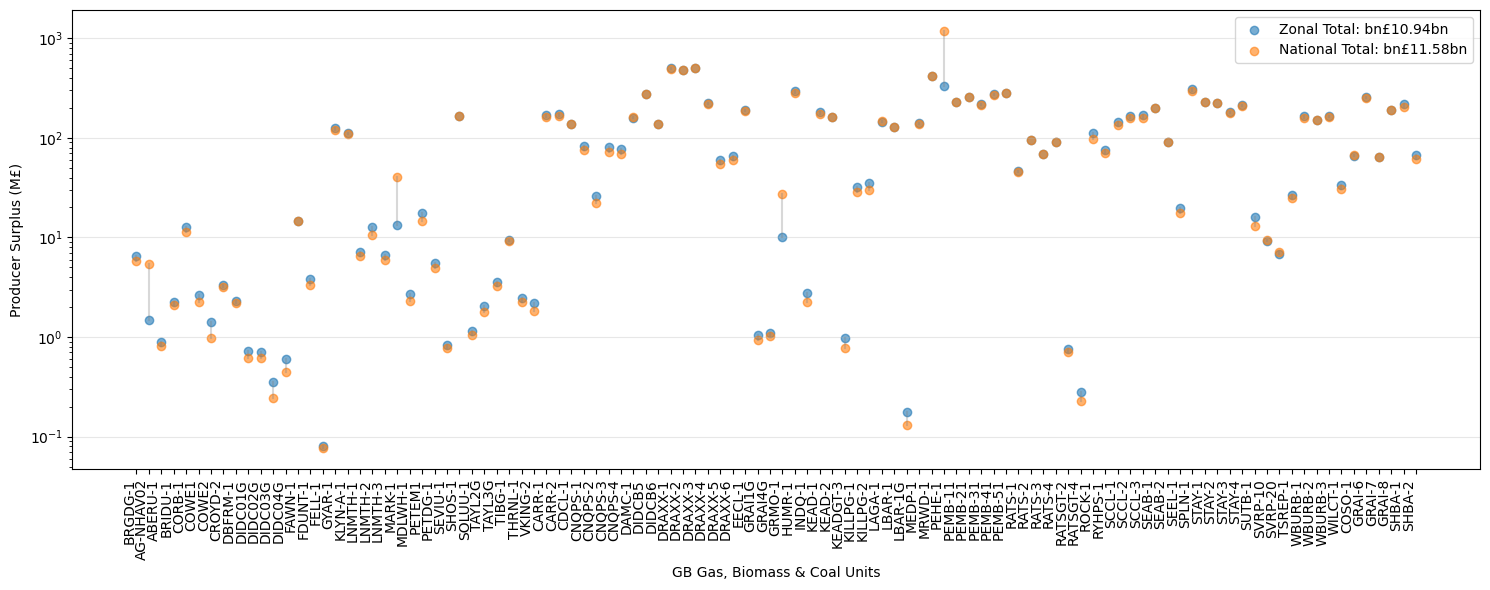

In [49]:
# Create scatter plot of profits
plt.figure(figsize=(15, 6))
x = range(len(zonal_overview))
plt.scatter(x, zonal_overview['profit'], label='Zonal Total: bn£' + str(round(zonal_overview['profit'].sum() * 1e-3, 2)) + 'bn', alpha=0.6)
plt.scatter(x, national_overview['profit'], label='National Total: bn£' + str(round(national_overview['profit'].sum() * 1e-3, 2)) + 'bn', alpha=0.6)

# Connect corresponding points with lines
for i in range(len(x)):
    plt.plot([x[i], x[i]], 
             [zonal_overview['profit'].iloc[i], national_overview['profit'].iloc[i]], 
             'gray', alpha=0.3)

plt.xticks(x, zonal_overview.index, rotation=90, ha='right')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.ylabel('Producer Surplus (M£)')
plt.xlabel('GB Gas, Biomass & Coal Units')

plt.yscale('log')

print(balancing_markup)

# plt.savefig(f'thermal_unit_surplus_{balancing_markup}.pdf', bbox_inches='tight')
plt.tight_layout()

In [46]:
diff = zonal_total - n_total

In [47]:
hold = diff.to_frame().rename(columns={0: 'diff'})

hold['carrier'] = bmu_carriers[hold.index]

phold = hold.loc[hold['diff'] > 0]
phold = phold.groupby('carrier')['diff'].sum()

if phold.sum() > 0:
    phold /= phold.sum()

nhold = hold.loc[hold['diff'] < 0]
nhold = nhold.groupby('carrier')['diff'].sum().abs()

nhold /= nhold.sum()

nhold /= nhold.sum()
plus_mask = diff.loc[diff > 0].index

pos_total_change = np.around(diff.loc[plus_mask].sum() * 1e-9 / 3, decimals=2)
neg_total_change = np.around(diff.loc[diff < 0].sum() * 1e-9 / 3, decimals=2)

perc_change = (zonal_total / n_total) * 100 - 100

x = bmus.loc[n_total.index.intersection(bmus.index), 'lat'].astype(float)
perc_change = perc_change.loc[x.index]

def get_color(bmu):
    return carrier_colors[bmu_carriers[bmu]]

new_carriers = [bmu_carriers[bmu] for bmu in x.index]
used_carriers.update(new_carriers)

perc_change.loc[zonal_overview.index] = (zonal_overview['profit'] / national_overview['profit']) * 100 - 100

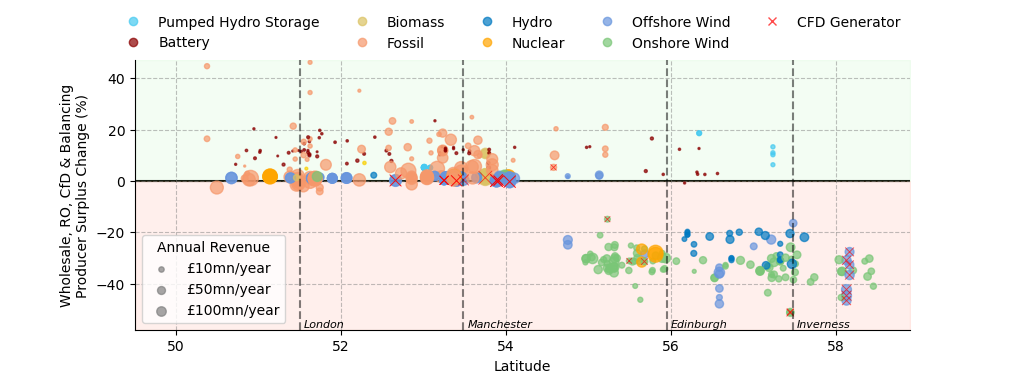

In [48]:
from matplotlib.lines import Line2D
import numpy as np

# Adjust this factor to scale circle sizes (smaller number = smaller circles)
CIRCLE_SCALE = 1.5

# Create main figure and axis
fig, ax = plt.subplots(1, 1, figsize=(10, 3.5))

# Create invisible axis for first legend
ax2 = fig.add_axes([0, 0, 1, 1])
ax2.set_axis_off()

# Convert revenue to millions per year and calculate circle sizes
sizes = n_total * 1e-6 / 3  # £mn/year
# Scale area not radius - need to take sqrt since scatter uses area
scaled_sizes = CIRCLE_SCALE * np.sqrt(sizes/sizes.min())

colors = list(map(get_color, x.index))

scatter = ax.scatter(
    x,
    perc_change,
    s=scaled_sizes,  # Use scaled sizes for area
    color=colors,
    alpha=0.7
    )

cfd_gens = x.index.intersection(cfd.index)
ax.scatter(
    x.loc[cfd_gens],
    perc_change.loc[cfd_gens],
    color='r',
    s=scaled_sizes[cfd_gens],  # Scale crosses same as circles
    alpha=0.7,
    marker='x',
    linewidth=0.6
    )

ax.grid(True, linestyle='--', color='grey', alpha=0.5)
ax.set_axisbelow(True)
ax.set_ylabel('Wholesale, RO, CfD & Balancing\nProducer Surplus Change (%)')

ax.axhline(0., c='k', zorder=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ylim_upper = 47
ylim_lower = -58

ax.set_ylim(ylim_lower, ylim_upper)
ax.set_xlim(49.5, 58.9)

ax.fill_between([49.5, 58.9], 0, ylim_upper, color='lightgreen', alpha=0.1, zorder=0)
ax.fill_between([49.5, 58.9], ylim_lower, 0, color='tomato', alpha=0.1, zorder=0)

# Build custom legend handles from the carriers that were used
legend_handles = []
legend_labels = []
for carrier in sorted(used_carriers):

    if carrier in ['cascade', 'solar']:
        continue

    color = carrier_colors.get(carrier, 'gray')
    handle = Line2D([0], [0], marker='o', linestyle='None',
                    markerfacecolor=color, markersize=6, markeredgecolor=color,
                    alpha=0.7)

    legend_handles.append(handle)
    legend_labels.append(nice_carrier_names[carrier])

legend_handles.append(
    Line2D(
        [0], [0],
        marker='x',
        color='r',
        markersize=6,
        markeredgecolor='r',
        alpha=0.7,
        linewidth=0.6,
        linestyle='None'
        )
)
legend_labels.append('CFD Generator')

# Add first legend to invisible axis
ax2.legend(
    legend_handles,
    legend_labels,
    loc='center',
    bbox_to_anchor=(0.5, 0.96),
    ncol=5,
    frameon=False)

ax.axvline(51.5, c='k', linestyle='--', alpha=0.5)
ax.text(51.55, -55.8, 'London', ha='left', va='center', fontsize=8, color='k', fontstyle='italic')

ax.axvline(53.48, c='k', linestyle='--', alpha=0.5)
ax.text(53.53, -55.8, 'Manchester', ha='left', va='center', fontsize=8, color='k', fontstyle='italic')

ax.axvline(55.95, c='k', linestyle='--', alpha=0.5)
ax.text(56.0, -55.8, 'Edinburgh', ha='left', va='center', fontsize=8, color='k', fontstyle='italic')

ax.axvline(57.48, c='k', linestyle='--', alpha=0.5)
ax.text(57.53, -55.8, 'Inverness', ha='left', va='center', fontsize=8, color='k', fontstyle='italic')

# Add size legend
legend_sizes = [10, 50, 100]  # £mn/year values to show
legend_scatter = []
for size in legend_sizes:
    legend_scatter.append(
        ax.scatter([], [], 
                  s=CIRCLE_SCALE * np.sqrt(size/sizes.min()),
                  c='gray',
                  alpha=0.7)
    )

size_legend = ax.legend(legend_scatter,
                       [f'£{size}mn/year' for size in legend_sizes],
                       loc='lower left',
                       title='Annual Revenue',
                       frameon=True,
                       scatterpoints=1)

ax.set_xlabel('Latitude')

plt.savefig(f'annual_unit_revenues_{balancing_markup}.pdf', bbox_inches='tight')
plt.show()

In [49]:
zonal_total

ABERU-1    1.010829e+07
ABRBO-1    1.933802e+08
ABRTW-1    4.193304e+07
ACHRW-1    4.061343e+07
AFTOW-1    4.904585e+07
               ...     
WLNYO-3    7.623571e+08
WLNYO-4    7.861620e+08
WLNYW-1    5.139945e+08
WTMSO-1    7.210461e+08
ZEN02A     1.839926e+06
Length: 404, dtype: float64

In [50]:
perc_change.loc[pd.Index(thermal_units).intersection(perc_change.index)].sort_values().head(10)

AG-NHAV02   -72.557198
PEHE-1      -71.785157
MARK-1      -66.602780
GRMO-1      -63.142719
SVRP-20      -4.127781
LAGA-1       -2.601026
SVRP-10      -2.594634
COSO-1       -2.084846
DAMC-1       -1.475068
RATS-2       -1.348658
dtype: float64

In [51]:
real_revs = pd.read_csv(
    Path.cwd().parent / 'summaries' / 'total_unit_revenues_flex.csv', index_col=[0,1,2]
)
real_revs = real_revs.loc[~real_revs.index.get_level_values(0).isin(intercon_lats.index)]

In [52]:
ss = real_revs.sum(axis=1)

simple = ss.groupby(level=[0,1]).sum().unstack().dropna()
# simple['zonal'].div(simple['national']).hist()

perc_change_2 = (100 * simple['zonal'].div(simple['national']) - 100).clip(upper=0)
perc_change_3 = (100 * simple['equitable'].div(simple['national']) - 100).clip(upper=0)

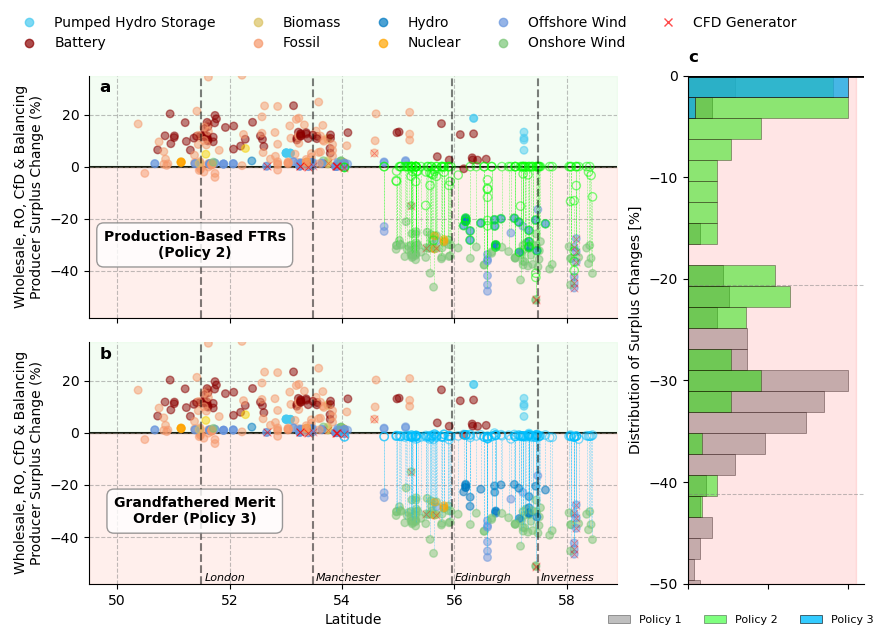

In [53]:
from matplotlib.lines import Line2D

# Create figure with 2 stacked axes on left and 1 tall axis on right
fig = plt.figure(figsize=(10, 6.6))
gs = fig.add_gridspec(2, 2, width_ratios=[3, 1], height_ratios=[1, 1])
axs = [fig.add_subplot(gs[0,0]), fig.add_subplot(gs[1,0])]
hist_ax = fig.add_subplot(gs[:,1])

idx = pd.IndexSlice

used_carriers = set()

n_total = n.replace(np.nan, 0).groupby(level=0).sum().sum(axis=1)
n_total = n_total[n_total > 0]

zonal_total = z.replace(np.nan, 0).groupby(level=0).sum().sum(axis=1)
zonal_total = zonal_total.loc[n_total.index]

zonal_total.drop(intercon_lats.index.intersection(zonal_total.index), inplace=True)
n_total.drop(intercon_lats.index.intersection(n_total.index), inplace=True)

diff = zonal_total - n_total

hold = diff.to_frame().rename(columns={0: 'diff'})

hold['carrier'] = bmu_carriers[hold.index]

phold = hold.loc[hold['diff'] > 0]
phold = phold.groupby('carrier')['diff'].sum()

if phold.sum() > 0:
    phold /= phold.sum()

    if len(phold) > 1:
        coords = [0.68, 0.9, 0.235, 0.05]
        plot_carrier_share(phold, ax, coords)

nhold = hold.loc[hold['diff'] < 0]
nhold = nhold.groupby('carrier')['diff'].sum().abs()

nhold /= nhold.sum()

if len(nhold) > 1:
    coords = [0.1, 0.233, 0.255, 0.05]
    plot_carrier_share(nhold, ax, coords)

nhold /= nhold.sum()
plus_mask = diff.loc[diff > 0].index

pos_total_change = np.around(diff.loc[plus_mask].sum() * 1e-9 / 3, decimals=2)
neg_total_change = np.around(diff.loc[diff < 0].sum() * 1e-9 / 3, decimals=2)

perc_change = (zonal_total / n_total) * 100 - 100

x = bmus.loc[n_total.index.intersection(bmus.index), 'lat'].astype(float)
perc_change = perc_change.loc[x.index]

perc_change.loc[zonal_overview.index] = (zonal_overview['profit'] / national_overview['profit']) * 100 - 100

def get_color(bmu):
    return carrier_colors[bmu_carriers[bmu]]

new_carriers = [bmu_carriers[bmu] for bmu in x.index]
used_carriers.update(new_carriers)

colors = list(map(get_color, x.index))

# Add bold labels A, B, C
axs[0].text(0.02, 0.98, 'a', transform=axs[0].transAxes, fontweight='bold', fontsize=12, va='top')
axs[1].text(0.02, 0.98, 'b', transform=axs[1].transAxes, fontweight='bold', fontsize=12, va='top')
hist_ax.text(-0.0, 1.05, 'c', transform=hist_ax.transAxes, fontweight='bold', fontsize=12, va='top')

for ax, policy_values, c, name in zip(
    axs,
    [perc_change_2, perc_change_3],
    [policy_colors['zonal'], policy_colors['zonal_with_policy']],
    ['Production-Based FTRs\n(Policy 2)', 'Grandfathered Merit\nOrder (Policy 3)']
    ):
    
    ax.scatter(
        x,
        perc_change,
        color=colors,
        s=30,
        alpha=0.5
        )
    
    offset = 1.6

    intersection = perc_change.index.intersection(policy_values.index)
    for (x0, lower, upper) in zip(x.loc[intersection], perc_change.loc[intersection], policy_values.loc[intersection]):
        if lower > 0:
            continue
        ax.plot([x0, x0], [lower+offset, upper-offset], c=c, alpha=0.5, linestyle='--', linewidth=0.4)
        ax.scatter([x0], [upper], alpha=0.5, marker='o', facecolors='none', color=c)

    cfd_gens = x.index.intersection(cfd.index)
    ax.scatter(
        x.loc[cfd_gens],
        perc_change.loc[cfd_gens],
        color='r',
        s=30,
        alpha=0.4,
        marker='x',
        linewidth=0.6
        )

    ax.grid(True, linestyle='--', color='grey', alpha=0.5)
    ax.set_axisbelow(True)
    ax.set_ylabel('Wholesale, RO, CfD & Balancing\nProducer Surplus Change (%)')

    ax.axhline(0., c='k', zorder=0)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ylim_upper = 35
    ylim_lower = -58

    ax.set_ylim(ylim_lower, ylim_upper)
    ax.set_xlim(49.5, 58.9)

    ax.fill_between([49.5, 58.9], 0, ylim_upper, color='lightgreen', alpha=0.1, zorder=0)
    ax.fill_between([49.5, 58.9], ylim_lower, 0, color='tomato', alpha=0.1, zorder=0)

    legend_handles = []
    legend_labels = []
    for carrier in sorted(used_carriers):
        if carrier in ['cascade', 'solar']:
            continue
        color = carrier_colors.get(carrier, 'gray')
        handle = Line2D([0], [0], marker='o', linestyle='None',
                        markerfacecolor=color, markersize=6, markeredgecolor=color,
                        alpha=0.7)
        legend_handles.append(handle)
        legend_labels.append(nice_carrier_names[carrier])

    legend_handles.append(
        Line2D(
            [0], [0],
            marker='x',
            color='r',
            markersize=6,
            markeredgecolor='r',
            alpha=0.7,
            linewidth=0.6,
            linestyle='None'
            )
    )
    legend_labels.append('CFD Generator')

    ax.axvline(51.5, c='k', linestyle='--', alpha=0.5)
    ax.axvline(53.48, c='k', linestyle='--', alpha=0.5)
    ax.axvline(55.95, c='k', linestyle='--', alpha=0.5)
    ax.axvline(57.48, c='k', linestyle='--', alpha=0.5)

    text_box = ax.text(0.2, 0.3, name, transform=ax.transAxes, 
                      ha='center', va='center', fontsize=10, weight='bold')
    text_box.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle='round,pad=0.5'))

# Plot combined histogram
bins = np.linspace(-60, 0, 30)  # Increased number of bins

# Get negative values and compute histograms
neg_perc_change = perc_change[perc_change < 0]
neg_policy2 = perc_change_2[perc_change_2 < 0] 
neg_policy3 = perc_change_3[perc_change_3 < 0]

# Calculate histograms
hist1, _ = np.histogram(neg_perc_change, bins=bins)
hist2, _ = np.histogram(neg_policy2, bins=bins)
hist3, _ = np.histogram(neg_policy3, bins=bins)

# Normalize to same max height
hist1 = hist1 / hist1.max()
hist2 = hist2 / hist2.max()
hist3 = hist3 / hist3.max()

bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot normalized histograms horizontally
hist_ax.barh(bin_centers, hist1, height=(bins[1]-bins[0]), alpha=0.5, color='gray',
           label='Policy 1', edgecolor='black', linewidth=0.5)
hist_ax.barh(bin_centers, hist2, height=(bins[1]-bins[0]), alpha=0.5, color=policy_colors['zonal'],
           label='Policy 2', edgecolor='black', linewidth=0.5)
hist_ax.barh(bin_centers, hist3, height=(bins[1]-bins[0]), alpha=0.8, color=policy_colors['zonal_with_policy'],
           label='Policy 3', edgecolor='black', linewidth=0.5)

# Add red background for negative values
hist_ax.axvspan(0, hist_ax.get_xlim()[1], ymin=0, ymax=1, color='red', alpha=0.1)

hist_ax.set_ylim(-50, 0)  # Decreased y-axis extent
hist_ax.set_ylabel('Distribution of Surplus Changes [%]')
hist_ax.legend(loc='lower center', bbox_to_anchor=(0.3, -0.1), ncol=3, frameon=False, fontsize=8)  # Legend at bottom
hist_ax.spines['right'].set_visible(False)
hist_ax.spines['top'].set_visible(False)
hist_ax.axhline(0, c='k', linestyle='-', alpha=1, lw=2)
hist_ax.axhline(-20.6, c='grey', linestyle='--', alpha=0.5, lw=0.75)
hist_ax.axhline(-41.2, c='grey', linestyle='--', alpha=0.5, lw=0.75)

hist_ax.set_xticklabels([])

axs[1].text(51.55, -55.8, 'London', ha='left', va='center', fontsize=8, color='k', fontstyle='italic')
axs[1].text(53.53, -55.8, 'Manchester', ha='left', va='center', fontsize=8, color='k', fontstyle='italic')
axs[1].text(56.0, -55.8, 'Edinburgh', ha='left', va='center', fontsize=8, color='k', fontstyle='italic')
axs[1].text(57.53, -55.8, 'Inverness', ha='left', va='center', fontsize=8, color='k', fontstyle='italic')

axs[0].legend(
    legend_handles,
    legend_labels,
    loc='upper center',
    bbox_to_anchor=(0.6, 1.3),
    ncol=5,
    frameon=False)

axs[0].set_xticklabels('')
axs[1].set_xlabel('Latitude')

plt.subplots_adjust(hspace=0.1)
plt.savefig(f'surplus_changes_{balancing_markup}_after_policy.pdf', bbox_inches='tight')
plt.show()

##### SEB Top-Down Calculation (to ensure alignement with the bottom-up method)

In [1]:
from pathlib import Path

from data_getter import get_dispatch_data, get_revenue_data, get_unit_schedule, get_unit_revenue

In [ ]:
disp_file = Path.cwd().parent / 'summaries' / 'total_unit_dispatch_flex.csv'
disp = get_dispatch_data(disp_file)

rev_file = Path.cwd().parent / 'summaries' / 'total_unit_revenues_flex.csv'
rev = get_revenue_data(rev_file)

c:\Users\lukas\OneDrive\Desktop\projects\nodal\UKLMP\notebooks\data_getter.py:58: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  disp = pd.read_csv(
c:\Users\lukas\OneDrive\Desktop\projects\nodal\UKLMP\notebooks\data_getter.py:58: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  disp = pd.read_csv(
c:\Users\lukas\OneDrive\Desktop\projects\nodal\UKLMP\notebooks\data_getter.py:58: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  disp = pd.read_csv(


In [ ]:
example_slice = slice(pd.Timestamp('2023-02-01'), pd.Timestamp('2023-02-28'))
# Get schedule for ABRBO-1 in zonal market, excluding 2023-01
time_slice = pd.DatetimeIndex(pd.date_range('2024-01-01', '2024-12-31'))

red_schedule = get_unit_schedule(disp, 'ABRBO-1', 'national', 'redispatch', time_slice)
who_schedule = get_unit_schedule(disp, 'ABRBO-1', 'national', 'wholesale', time_slice)

C:\Users\lukas\AppData\Local\Temp\ipykernel_31676\3126580922.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  rev = pd.read_csv(
C:\Users\lukas\AppData\Local\Temp\ipykernel_31676\3126580922.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  rev = pd.read_csv(
C:\Users\lukas\AppData\Local\Temp\ipykernel_31676\3126580922.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  rev = pd.read_csv(


In [112]:


get_unit_revenue(rev, unit, 'zonal', time_slice)

139496149.8683082

In [113]:
from pathlib import Path
import matplotlib.pyplot as plt

import yaml
import numpy as np
import pandas as pd

with open(Path.cwd().parent / 'data' / 'interconnection_helpers.yaml', 'r') as f:
    interconnection_capacities = yaml.safe_load(f)

country_mapper = interconnection_capacities['interconnection_countries']

In [55]:
# Load data globally
path = Path.cwd().parent / 'summaries'

marginal_prices = pd.read_csv(path / 'marginal_prices_summary_flex.csv', index_col=[0], parse_dates=True, header=[0,1])
marginal_prices.index = marginal_prices.index.strftime('%Y-%m-%d %H:%M:%S')

revenues = pd.read_csv(
    Path.cwd().parent / 'summaries' / 'total_summary_flex.csv',
    index_col=[0,1],
    parse_dates=True
)

cons = pd.read_csv(path / 'total_intercon_dispatch_flex.csv', index_col=[0], parse_dates=True, header=[0,1])

imports = cons.clip(lower=0)
exports = cons.clip(upper=0).abs()

imports.index = imports.index.strftime('%Y-%m-%d %H:%M:%S')
exports.index = exports.index.strftime('%Y-%m-%d %H:%M:%S')

days = pd.date_range(start='2022-01-01', end='2024-12-31', freq='D').strftime('%Y-%m-%d')

prices = []
for day in days:
    try:
        prices.append(
            pd.read_csv(
                Path.cwd().parent / 'data' / 'base' / day / 'europe_day_ahead_prices.csv',
                index_col=0,
                parse_dates=True,
            )
        )
    except FileNotFoundError:
        print(f'No prices for {day}')

europe_prices = pd.concat(prices)
europe_prices.index = pd.to_datetime(europe_prices.index)
europe_prices.index = europe_prices.index.strftime('%Y-%m-%d %H:%M:%S')

ics = cons.columns.get_level_values(0).unique()

import pypsa
n = pypsa.Network(
    Path.cwd().parent / 'results' / '2024-03-21' / 'network_flex_s_nodal.nc'
)

zonal_intercon_buses = n.links.loc[ics, 'bus1']
intercon_countries = n.links.loc[ics, 'bus0']

flows = imports + exports

C:\Users\lukas\AppData\Local\Temp\ipykernel_2444\1661198770.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  revenues = pd.read_csv(


No prices for 2022-01-04
No prices for 2024-02-19
No prices for 2024-03-06


INFO:pypsa.io:Imported network network_flex_s_nodal.nc has buses, carriers, generators, links, loads, storage_units


In [57]:
def get_export_revenues(ts, name, prices):

    local_intersect = prices.index.intersection(ts.index)

    return pd.Series(
        ts.loc[local_intersect].values * prices.loc[local_intersect].values,
        index=local_intersect,
        name=name
    )


In [62]:
idx = pd.IndexSlice

keepers = ['bid_cost', 'cfd', 'offer_cost', 'roc', 'wholesale']

z = p.loc[idx[:,'zonal', keepers], :]
n = p.loc[idx[:,'national', keepers], :]

z.index = z.index.droplevel(1)
n.index = n.index.droplevel(1)

# Rename index values in level 1 for both dataframes
rename_dict = {
    'cfd': 'cfd_revenue',
    'roc': 'roc_revenue',
    'wholesale': 'wholesale_revenue'
}

# Apply renaming to z dataframe
z.index = pd.MultiIndex.from_tuples(
    [(asset, rename_dict.get(revenue_type, revenue_type)) 
     for asset, revenue_type in z.index],
    names=z.index.names
)

# Apply renaming to n dataframe
n.index = pd.MultiIndex.from_tuples(
    [(asset, rename_dict.get(revenue_type, revenue_type)) 
     for asset, revenue_type in n.index],
    names=n.index.names
)

n.sort_index(inplace=True)
z.sort_index(inplace=True)

C:\Users\lukas\AppData\Local\Temp\ipykernel_2444\3570653476.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n.sort_index(inplace=True)
C:\Users\lukas\AppData\Local\Temp\ipykernel_2444\3570653476.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z.sort_index(inplace=True)


In [73]:
idx = pd.IndexSlice

national_expenses = []
zonal_expenses = []

for unit in thermal_units:

    national_expenses.append(
        pd.Series(
            thermal_dispatch.loc[:, idx['national', unit]] * marginal_cost.loc[:, unit],
            index=marginal_cost.index,
            dtype=float,
            name=unit
        ).replace(np.nan, 0)
    )

    zonal_expenses.append(
        pd.Series(
            thermal_dispatch.loc[:, idx['zonal', unit]] * marginal_cost.loc[:, unit],
            index=marginal_cost.index,
            dtype=float,
            name=unit
        ).replace(np.nan, 0)
    )

ts_national_expenses = pd.concat(national_expenses, axis=1)# .sum()
ts_zonal_expenses = pd.concat(zonal_expenses, axis=1)# .sum()

In [116]:
def calculate_monthly_seb(year, month):

    # Filter data for specific month
    month_start = pd.Timestamp(f"{year}-{month:02d}-01")
    month_end = pd.Timestamp(f"{year}-{month:02d}-01") + pd.offsets.MonthEnd(1)
    month_mask = (pd.to_datetime(revenues.index.get_level_values(0)) >= month_start) & \
                 (pd.to_datetime(revenues.index.get_level_values(0)) <= month_end)
    month_strf = month_start.strftime('%Y-%m')

    n_total = n.replace(np.nan, 0).groupby(level=0).sum()
    n_total = n_total.loc[:, n_total.columns.str.contains(month_strf)].sum(axis=1)

    n_total = n_total[n_total > 0]

    zonal_total = z.replace(np.nan, 0).groupby(level=0).sum()
    zonal_total = zonal_total.loc[:, zonal_total.columns.str.contains(month_strf)].sum(axis=1)

    zonal_total.drop(intercon_lats.index.intersection(zonal_total.index), inplace=True)
    n_total.drop(intercon_lats.index.intersection(n_total.index), inplace=True)

    # print(n_total.shape)

    # Calculate congestion costs
    concosts_national = revenues['national'][month_mask].sum()
    concosts_zonal = revenues['zonal'][month_mask].sum()

    # print(ts_national_expenses)
    national_expenses = ts_national_expenses.loc[month_start:month_end].sum()
    zonal_expenses = ts_zonal_expenses.loc[month_start:month_end].sum()

    # Calculate thermal revenues and expenses
    thermal_national_revenues = n_total.loc[national_expenses.index.intersection(n_total.index)]
    thermal_zonal_revenues = zonal_total.loc[zonal_expenses.index.intersection(zonal_total.index)]

    national_overview = pd.concat([thermal_national_revenues.rename('revenue'), 
                                 national_expenses.rename('expenses')], axis=1).dropna()
    zonal_overview = pd.concat([thermal_zonal_revenues.rename('revenue'),
                              zonal_expenses.rename('expenses')], axis=1).dropna()

    # print(zonal_overview.shape)
    # Calculate balancing costs
    balancing_markup = 30 # £/MWh
    
    month_dispatch = dispatch.loc[:, month_start.strftime('%Y-%m-%d'):month_end.strftime('%Y-%m-%d')]
    
    zonal_balancing = pd.DataFrame(0, index=thermal_units, columns=month_dispatch.columns)
    zonal_balancing += month_dispatch.loc[idx[thermal_units, 'zonal', 'redispatch']].values
    zonal_balancing -= month_dispatch.loc[idx[thermal_units, 'zonal', 'wholesale']].values
    zonal_balancing_vol = zonal_balancing.clip(lower=0).sum(axis=1)

    national_balancing = pd.DataFrame(0, index=thermal_units, columns=month_dispatch.columns)
    national_balancing += month_dispatch.loc[idx[thermal_units, 'national', 'redispatch']].values
    national_balancing -= month_dispatch.loc[idx[thermal_units, 'national', 'wholesale']].values
    national_balancing_vol = national_balancing.clip(lower=0).sum(axis=1)

    zonal_overview['expenses'] += zonal_balancing_vol.loc[zonal_overview.index] * balancing_markup
    national_overview['expenses'] += national_balancing_vol.loc[national_overview.index] * balancing_markup

    zonal_overview['profit'] = (zonal_overview['revenue'] - zonal_overview['expenses']).mul(1e-6)
    national_overview['profit'] = (national_overview['revenue'] - national_overview['expenses']).mul(1e-6)

    # Calculate interconnector congestion rents
    zonal_congestion_rent = 0
    national_congestion_rent = 0

    month_flows = flows.loc[month_start.strftime('%Y-%m-%d %H:%M:%S'): month_end.strftime('%Y-%m-%d %H:%M:%S')]
    month_prices = marginal_prices.loc[month_start.strftime('%Y-%m-%d %H:%M:%S'): month_end.strftime('%Y-%m-%d %H:%M:%S')]
    month_europe_prices = europe_prices.loc[month_start.strftime('%Y-%m-%d %H:%M:%S'): month_end.strftime('%Y-%m-%d %H:%M:%S')]

    for name in ics:
        country = intercon_countries[name]
        zonal_bus = zonal_intercon_buses[name]

        timesteps = month_flows.index.intersection(month_prices.index).intersection(month_europe_prices.index)

        gb_national_prices = month_prices.loc[timesteps, idx['national', 'GB']]
        gb_zonal_prices = month_prices.loc[timesteps, idx['zonal', zonal_bus]]
        foreign_prices = month_europe_prices.loc[timesteps, country]

        zonal_flows = month_flows.loc[timesteps, idx[name, 'zonal']]
        national_flows = month_flows.loc[timesteps, idx[name, 'national']]

        zonal_rent = (zonal_flows * (foreign_prices - gb_zonal_prices).abs()).sum()
        national_rent = (national_flows * (foreign_prices - gb_national_prices).abs()).sum()

        zonal_congestion_rent += zonal_rent
        national_congestion_rent += national_rent

    ic_congestion_rent_diff = (zonal_congestion_rent - national_congestion_rent) / 2 / 1e6

    # Calculate export revenues
    month_exports = exports.loc[month_start.strftime('%Y-%m-%d %H:%M:%S'): month_end.strftime('%Y-%m-%d %H:%M:%S')]
    export_revenues_zonal = pd.DataFrame(index=timesteps, columns=month_exports.columns.get_level_values(0).unique())
    export_revenues_national = pd.DataFrame(index=timesteps, columns=month_exports.columns.get_level_values(0).unique())

    for name in export_revenues_zonal.columns:
        country = intercon_countries[name]
        zonal_bus = zonal_intercon_buses[name]

        ts_exports_zonal = month_exports.loc[timesteps, idx[name, 'zonal']]
        ts_exports_national = month_exports.loc[timesteps, idx[name, 'national']]

        gb_national_prices = month_prices.loc[timesteps, idx['national', 'GB']]
        gb_zonal_prices = month_prices.loc[timesteps, idx['zonal', zonal_bus]]

        export_revenues_zonal.loc[:, name] = get_export_revenues(ts_exports_zonal, name, gb_zonal_prices)
        export_revenues_national.loc[:, name] = get_export_revenues(ts_exports_national, name, gb_national_prices)

    export_rev_zonal = export_revenues_zonal.sum().sum() * 1e-6
    export_rev_national = export_revenues_national.sum().sum() * 1e-6

    # Calculate surpluses
    surplus_n = n_total.copy() * 1e-6
    surplus_n.loc[national_overview.index] = national_overview['profit']

    surplus_z = zonal_total.copy() * 1e-6
    surplus_z.loc[zonal_overview.index] = zonal_overview['profit']

    # print(ic_congestion_rent_diff)

    # Calculate final SEB
    return pd.Series({
        'congestion_costs': concosts_national - concosts_zonal,
        'producer_surplus': -(surplus_n.sum() - surplus_z.sum()),
        'export_revenue': -(export_rev_national - export_rev_zonal),
        'ic_congestion_rent': ic_congestion_rent_diff
    })


# Calculate SEB for each month
monthly_sebs = []
from itertools import product
from tqdm import tqdm

for year, month in tqdm(product(range(2022, 2025), range(1, 13))):
    seb_components = calculate_monthly_seb(year, month)
    monthly_sebs.append({
        'year': year,
        'month': month,
        **seb_components.to_dict()
    })

monthly_seb_df = pd.DataFrame(monthly_sebs)

36it [00:08,  4.13it/s]


In [117]:
monthly_seb_df.head()

,year,month,congestion_costs,producer_surplus,export_revenue,ic_congestion_rent
0,2022,1,453.078853,-447.120086,-14.430141,3.211865
1,2022,2,546.008563,-522.642584,-15.163983,4.257020
2,2022,3,287.506509,-273.503353,-7.909369,0.289457
3,2022,4,204.729841,-190.014085,-3.102327,0.268845
4,2022,5,266.841968,-238.341586,1.238160,-1.029941


<Axes: >

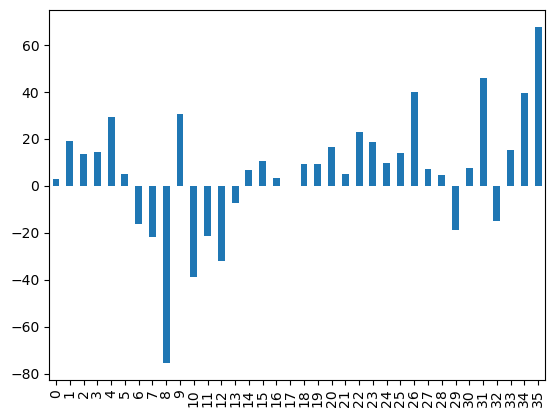

In [113]:
monthly_seb_df['seb'].plot.bar()

In [114]:
monthly_seb_df['seb'].sum()

222.1319260460865